In [1]:
pip install ray torch torchvision


     |████████████████████████████████| 49.7MB 61kB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 81kB 13.2MB/s 
     |████████████████████████████████| 81kB 12.2MB/s 
     |████████████████████████████████| 1.3MB 52.6MB/s 
     |████████████████████████████████| 3.1MB 41.1MB/s 
     |████████████████████████████████| 1.0MB 52.0MB/s 
     |████████████████████████████████| 133kB 57.6MB/s 
     |████████████████████████████████| 92kB 13.4MB/s 
     |████████████████████████████████| 143kB 52.8MB/s 
     |████████████████████████████████| 296kB 59.0MB/s 
  Created wheel for gpustat: filename=gpustat-0.6.0-cp37-none-any.whl size=12621 sha256=2bab8f7f7a61f03ab057c70b831ddba15117d2501e29eb43b7e4e44ad4090de9
  Stored in directory: /root/.cache/pip/wheels/48/b4/d5/fb5b7f1d040f2ff20687e3bad6867d63155dbde5a7c10f4293
Successfully built gpustat
  Found existing installation: protobuf 3.12.4
    Uninstalling protobuf-3.12.4:
      Successfully un

In [2]:
import random
from functools import partial
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, \
      f1_score, precision_score, recall_score, roc_auc_score
import pickle

import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
from sklearn import metrics


/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:

import torch
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
!pip install transformers

     |████████████████████████████████| 2.3MB 31.1MB/s 
     |████████████████████████████████| 901kB 45.8MB/s 
     |████████████████████████████████| 3.3MB 47.5MB/s 


In [7]:
#this is to load the local data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
import pandas as pd
def readFile():
  dirname = "seng607/test_negative_roi/Ruby"
  filename = "Ruby_train.csv"
  f_test = "Ruby_test.csv"
  df_org = pd.read_csv("/content/gdrive/MyDrive/"+dirname+"/"+filename)#, usecols=['req1', 'req2', 'Label'])

  df_test = pd.read_csv("/content/gdrive/MyDrive/"+dirname+"/"+f_test)#, usecols=['req1', 'req2', 'Label'])
  
  print(len(df_org), len(df_test))
  return df_org, df_test

In [9]:
df, df_test= readFile()
print(df)
print(df_test)

1431 361
      Unnamed: 0    id1  ... Type of dependency  Label
0           3840  10519  ...        independent      0
1            973   5749  ...            relates      1
2           1440   1411  ...        independent      0
3            628  10552  ...            relates      1
4           6849  14643  ...        independent      0
...          ...    ...  ...                ...    ...
1426        1041   5065  ...            relates      1
1427         769   8499  ...            relates      1
1428           7  17365  ...            relates      1
1429        1006  13199  ...            relates      1
1430         648  10152  ...            relates      1

[1431 rows x 7 columns]
     Unnamed: 0    id1  ... Type of dependency  Label
0          1172   7022  ...            relates      1
1          6987   3547  ...        independent      0
2           288  11541  ...            relates      1
3          1012  13248  ...            relates      1
4          4344  17039  ...        i

In [11]:
from transformers import BertTokenizer
def loadBert():
  # Load the BERT tokenizer.
  print('Loading BERT tokenizer...')
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  return tokenizer

In [ ]:
#  tokenizer = loadBert() 

Loading BERT tokenizer...


In [12]:
from transformers import BertModel, AdamW, BertConfig, BertForNextSentencePrediction
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForNextSentencePrediction.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForNextSentencePrediction: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForNextSentencePrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [13]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [14]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [15]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [16]:
def recover_checkpoint(tune_checkpoint_dir, model_name=None):
    if tune_checkpoint_dir is None or len(tune_checkpoint_dir) == 0:
        return model_name
    # Get subdirectory used for Huggingface.
    subdirs = [
        os.path.join(tune_checkpoint_dir, name)
        for name in os.listdir(tune_checkpoint_dir)
        if os.path.isdir(os.path.join(tune_checkpoint_dir, name))
    ]
    # There should only be 1 subdir.
    assert len(subdirs) == 1, subdirs
    return subdirs[0]

In [17]:
from sklearn.model_selection import cross_val_score,train_test_split
import random
import numpy as np
def trainingProcess(config,df,checkpoint_dir=None):
      print("************************************************************")
      print("Training Process begins now...........")
      optimizer = AdamW(model.parameters(),
                    lr = config["lr"], 
                    # lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

      if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)


      print("Step 1: tokenize")

    # performTokonize
      max_seq_length = 256
      input_ids=[]
      token_type_ids = []

      for index, row in df.iterrows(): 
          encoded_dict = tokenizer.encode_plus(row['req1'],row['req2'],max_length=256, pad_to_max_length=True, truncation=True)
          input_ids.append(encoded_dict['input_ids'])
          token_type_ids.append(encoded_dict['token_type_ids'])
      input_ids = torch.tensor(input_ids)#,dtype=torch.long)
      token_type_ids = torch.tensor(token_type_ids)#,dtype=torch.long)

      print("Step 2: split into train validation")
    # trainTestSplit
      from torch.utils.data import TensorDataset, random_split

      labels = df.Label.values
      dataset = TensorDataset(input_ids, token_type_ids, torch.tensor(labels))
      train_size = int(.9 * len(dataset))
      val_size = len(dataset) - train_size
      train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
      print('{:>5,} training samples'.format(train_size))
      print('{:>5,} validation samples'.format(val_size))
    # return train_dataset, val_dataset

      print("Step 3: data loading")
  # dataloading
      from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

      batch_size=int(config["batch_size"])
      # batch_size=32

    ## Create the DataLoaders for our training and validation sets.
    ## We'll take training samples in random order. 
      train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

    ## For validation the order doesn't matter, so we'll just read them sequentially.
      validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
    # return train_dataloader, validation_dataloader

      print("Step 4: set scheduler and traning epochs")
  # trainingepochs
      from transformers import get_linear_schedule_with_warmup

      epochs = int(config["num_epochs"])
      # epochs = 3

    # #Total number of training steps is [number of batches] x [number of epochs]. 
    # #(Note that this is not the same as the number of training samples).
      total_steps = len(train_dataloader) * epochs

    # #Create the learning rate scheduler.
      scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
    # return epochs,total_steps, scheduler


      print("Step 5: Training the model begins now")
  # training

  # def training(train_dataloader,validation_dataloader, epochs, total_steps, scheduler):
      # #Help by
      ##https://github.com/Shivampanwar/Bert-text-classification/blob/master/bert_language_model_with_sequence_classification.ipynb

      ## This training code is based on the `run_glue.py` script here:
      ## https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

      # #Set the seed value all over the place to make this reproducible.
      seed_val = 42

      random.seed(seed_val)
      np.random.seed(seed_val)
      torch.manual_seed(seed_val)
      torch.cuda.manual_seed_all(seed_val)

      # #We'll store a number of quantities such as training and validation loss, 
      # #validation accuracy, and timings.
      training_stats = []

      # #Measure the total training time for the whole run.
      total_t0 = time.time()

      # #Store our loss and accuracy for plotting
      train_loss_set = []

      total_step = len(train_dataloader)

      # #For each epoch...
      for epoch_i in range(0, epochs):
          
          # ========================================
          #               Training
          # ========================================
          
          # #Perform one full pass over the training set.

          print("")
          print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
          print('Training...')

          # #Measure how long the training epoch takes.
          t0 = time.time()

          # #Reset the total loss for this epoch.
          total_train_loss = 0

          # #Put the model into training mode. Don't be mislead--the call to 
          # ##`train` just changes the *mode*, it doesn't *perform* the training.
          # #`dropout` and `batchnorm` layers behave differently during training
          # #vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
          model.train()

          # #For each batch of training data...
          for step, batch in enumerate(train_dataloader):

              # #Progress update every 40 batches.
              if step % 40 == 0 and not step == 0:
                  # #Calculate elapsed time in minutes.
                  elapsed = format_time(time.time() - t0)
                  
                  # #Report progress.
                  print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

              # #Unpack this training batch from our dataloader. 
              ##
              # #As we unpack the batch, we'll also copy each tensor to the GPU using the 
              # #`to` method.
              ##
              # #`batch` contains three pytorch tensors:
              # #  [0]: input ids 
              # #  [1]: attention masks
              # #  [2]: labels 
              b_input_ids = batch[0].to(device)
              b_token_type_ids = batch[1].to(device)
              b_labels = batch[2].to(device)

              # #Always clear any previously calculated gradients before performing a
              # #backward pass. PyTorch doesn't do this automatically because 
              # #accumulating the gradients is "convenient while training RNNs". 
              # #(source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
              model.zero_grad()        

              # #Perform a forward pass (evaluate the model on this training batch).
              # ##The documentation for this `model` function is here: 
              # #https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # #It returns different numbers of parameters depending on what arguments
              # #arge given and what flags are set. For our useage here, it returns
              # #the loss (because we provided labels) and the "logits"--the model
              # #outputs prior to activation.
              ##loss,logits = model(b_input_ids, 
              #                     token_type_ids=b_token_type_ids, attention_mask=None, next_sentence_label=b_labels)
              
              output = model(b_input_ids, token_type_ids=b_token_type_ids, attention_mask=None, next_sentence_label=b_labels)
              loss, logits=output[:2]
              
              ##print(output[0])
              ##input("hit enter")
              ##loss = output[0]
              # #Accumulate the training loss over all of the batches so that we can
              # #calculate the average loss at the end. `loss` is a Tensor containing a
              # #single value; the `.item()` function just returns the Python value 
              # #from the tensor.
              total_train_loss += loss.item()
              ##train_loss_set.append(loss.item())  

              # #Perform a backward pass to calculate the gradients.
              loss.backward()

              # #Clip the norm of the gradients to 1.0.
              # #This is to help prevent the "exploding gradients" problem.
              torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

              # #Update parameters and take a step using the computed gradient.
              # #The optimizer dictates the "update rule"--how the parameters are
              # #modified based on their gradients, the learning rate, etc.
              optimizer.step()

              # #Update the learning rate.
              scheduler.step()

          # #Calculate the average loss over all of the batches.
          avg_train_loss = total_train_loss / len(train_dataloader)            
          
          # #Measure how long this epoch took.
          training_time = format_time(time.time() - t0)

          print("")
          print("  Average training loss: {0:.2f}".format(avg_train_loss))
          print("  Training epcoh took: {:}".format(training_time))
              
          # #========================================
          #  #             Validation
          # #========================================
          # #After the completion of each training epoch, measure our performance on
          # #our validation set.

          print("")
          print("Running Validation...")

          t0 = time.time()

          # #Put the model in evaluation mode--the dropout layers behave differently
          # #during evaluation.
          model.eval()

          # #Tracking variables 
          total_eval_accuracy = 0
          total_eval_loss = 0
          nb_eval_steps = 0

          # #Evaluate data for one epoch
          for batch in validation_dataloader:
              
              # #Unpack this training batch from our dataloader. 
              ##
              # #As we unpack the batch, we'll also copy each tensor to the GPU using 
              # #the `to` method.
              # #
              # #`batch` contains three pytorch tensors:
              # #  [0]: input ids 
              # #  [1]: attention masks
              # #  [2]: labels 
              b_input_ids = batch[0].to(device)
              b_token_type_ids = batch[1].to(device)
              b_labels = batch[2].to(device)
              
              # #Tell pytorch not to bother with constructing the compute graph during
              # #the forward pass, since this is only needed for backprop (training).
              with torch.no_grad():        

                  # #Forward pass, calculate logit predictions.
                  # #token_type_ids is the same as the "segment ids", which 
                  # #differentiates sentence 1 and 2 in 2-sentence tasks.
                  # #The documentation for this `model` function is here: 
                  # #https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                  # #Get the "logits" output by the model. The "logits" are the output
                  # #values prior to applying an activation function like the softmax.
                  # #(loss, logits) = model(b_input_ids, 
                  #  #                token_type_ids=b_token_type_ids, attention_mask=None, next_sentence_label=b_labels)
                  
                  outputs = model(b_input_ids, 
                                  token_type_ids=b_token_type_ids, attention_mask=None, next_sentence_label=b_labels)
                  
                  #_, #preds = torch.max(outputs, dim=1)
                  loss, logits = outputs[:2]

              # #Accumulate the validation loss.
              total_eval_loss += loss.item()
                  
              # #Move logits and labels to CPU
              logits = logits.detach().cpu().numpy()
              label_ids = b_labels.to('cpu').numpy()

              # #Calculate the accuracy for this batch of test sentences, and
              # #accumulate it over all batches.
              total_eval_accuracy += flat_accuracy(logits, label_ids)
              

          # #Report the final accuracy for this validation run.
          avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
          print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

          # #Calculate the average loss over all of the batches.
          avg_val_loss = total_eval_loss / len(validation_dataloader)
          
          # #Measure how long the validation run took.
          validation_time = format_time(time.time() - t0)
          
          print("  Validation Loss: {0:.2f}".format(avg_val_loss))
          print("  Validation took: {:}".format(validation_time))

           
          # report to tune end of each epoch
          # tune.report(loss=(val_loss / val_steps), accuracy=correct / total)


        #  hyperParameter Tuning 
          with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
               path = os.path.join(checkpoint_dir, "checkpoint")
               torch.save(
                (model.state_dict(), optimizer.state_dict()), path)
            
          tune.report(eval_acc=avg_val_accuracy)

        #  hyperParameter Tuning   

          # #Record all statistics from this epoch.
          training_stats.append(
              {
                  'epoch': epoch_i + 1,
                  'Training Loss': avg_train_loss,
                  'Valid. Loss': avg_val_loss,
                  'Valid. Accur.': avg_val_accuracy,
                  'Training Time': training_time,
                  'Validation Time': validation_time
              }
          )

      print("")
      print("Training complete!")

      print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
      # return training_stats

  # draw_table
      # Display floats with two decimal places.
      pd.set_option('precision', 2)

      # Create a DataFrame from our training statistics.
      df_stats = pd.DataFrame(data=training_stats)

      # Use the 'epoch' as the row index.
      df_stats = df_stats.set_index('epoch')

      # A hack to force the column headers to wrap.
      #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

      # Display the table.
      print(df_stats)


  # plot_loss

      import matplotlib.pyplot as plt
      % matplotlib inline

      import seaborn as sns
  # def plot_loss(df_stats):
        # Use plot styling from seaborn.
      sns.set(style='darkgrid')

      # Increase the plot size and font size.
      sns.set(font_scale=1.5)
      plt.rcParams["figure.figsize"] = (12,6)

      # Plot the learning curve.
      plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
      plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

      # Label the plot.
      plt.title("Training & Validation Loss")
      plt.xlabel("Epoch")
      plt.ylabel("Loss")
      plt.legend()
      plt.xticks([1, 2, 3])

      plt.show()

In [18]:
import pandas as pd
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix, \
     f1_score, precision_score, recall_score, roc_auc_score
import pickle
import matplotlib
matplotlib.use('agg')
from matplotlib import pyplot as plt
from sklearn import metrics
# def testingProcess(config,df_test):
def testingProcess(model,best_bS,df_test):

      df=df_test
      print("Step 6: Testing data loading...................")
# validation

# def validation(df):
      # Report the number of sentences.
      print('Number of test sentences: {:,}\n'.format(df.shape[0]))

      max_seq_length = 256
      input_ids=[]
      token_type_ids = []
      labels = df.Label.values
      print(df.Label.value_counts())

      for index, row in df.iterrows(): 
          #print (row["Name"], row["Age"]) 
          #print(row['req1'], " --- ", row['req2'])
          #req1,req2 = checkLength((row['req1'],(row['req2'])
          encoded_dict = tokenizer.encode_plus(row['req1'],row['req2'],max_length=256, pad_to_max_length=True,truncation=True)
          #print(encoded_dict['input_ids'])
          #print(encoded_dict['token_type_ids'])
          input_ids.append(encoded_dict['input_ids'])
          token_type_ids.append(encoded_dict['token_type_ids'])
          #break;

      input_ids = torch.tensor(input_ids)#,dtype=torch.long)
      token_type_ids = torch.tensor(token_type_ids)#,dtype=torch.long)
      labels = torch.tensor(labels)
    # Set the batch size.  

      # batch_size = int(config["batch_size"])
      batch_size = best_bS

      # batch_size = 32

    # Create the DataLoader.
      prediction_data = TensorDataset(input_ids, token_type_ids, labels)
      prediction_sampler = SequentialSampler(prediction_data)
      prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    # return prediction_dataloader

# evaluate
      print("Step 6: Testing begins")
      test_predictions=[]
      s_prediction = []
      with torch.no_grad():
        correct = 0
        total = 0
        for i, batch in enumerate(prediction_dataloader):
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_token_type_id, b_labels = batch
            # Forward pass
            
            outputs = model(b_input_ids, token_type_ids=b_token_type_id)
            # print (outputs)
            prediction = torch.argmax(outputs[0],dim=1)
            total += b_labels.size(0)
            correct+=(prediction==b_labels).sum().item()
            test_predictions.append(prediction)
            
            softmax = torch.nn.Softmax(dim=1)
            prob = softmax(outputs[0])
            s_prediction.append([t.item() for t in list(prediction)])

      flat_list = [item for sublist in s_prediction for item in sublist]
      print(correct, total)
      print(s_prediction)
      print('Test Accuracy of the model on val data is: {} %'.format(100 * correct / total))
      accuracy = accuracy_score(df.Label.values, flat_list)
      matthews = matthews_corrcoef(df.Label.values, flat_list)
      print("Accuracy is: ", accuracy, "      Mathews corrCoef is: ", matthews)
      # print(accuracy, matthews)
      df['prediction'] = flat_list
      # return flat_list, df

      # plottingpreds


      # def plottingpreds(flat_list):
      pred=flat_list

      lbl=1
      precisions = {}
      recalls = {}
      f1s = {}
      aucrocs = {}

      label_name=[0,lbl]
      prediction = flat_list
      for i in range(len(label_name)):
          prediction_ = [1 if pred == i else 0 for pred in prediction]
          true_ = [1 if label == i else 0 for label in df.Label.values]
          f1s.update({label_name[i]: f1_score(true_, prediction_)})
          precisions.update({label_name[i]: precision_score(true_, prediction_)})
          recalls.update({label_name[i]: recall_score(true_, prediction_)})
          #aucrocs.update({label_name[i]: roc_auc_score(true_, list(t.item() for t in prob[:, i]))})
      # metrics_dict = {'accuracy': accuracy, 'matthews coef': matthews, 'precision': precisions, 'recall': recalls, 'f1': f1s}#, 'aucroc': aucrocs}

      #pickle.dump(metrics_dict, open('evaluation_metrics', 'wb'))

      # cm = plot_confusion_matrix(list(df.Label.values), prediction, label_name, normalize=False,
      #                           path='test_confusion_matrix', title='confusion matrix for test dataset')
   # plt.savefig('test_confusion_matrix', format='png')
  # cm_norm = plot_confusion_matrix(list(df.Label.values), prediction, label_name, normalize=True,
  #                           path='test normalized_confusion_matrix', title='normalized confusion matrix for test dataset')
  # plt.savefig('test_normalized_confusion_matrix', format='png')
      print("cm:",metrics.confusion_matrix(list(df.Label.values), prediction, label_name))
      print([["TN","FP"],
         ["FN","TP"]])

  # print('cm',list(df.Label.values))

      for i in range(len(label_name)):
          print('precision score for %s: %.2f' % (label_name[i], precisions[label_name[i]]))
          print('recall score for %s: %.2f' % (label_name[i], recalls[label_name[i]]))
          print('f1 score for %s: %.2f' % (label_name[i], f1s[label_name[i]]))



In [ ]:
# def main(df, df_test):
# # train_size = [150,300,450,600,750,900,1050,1200,1350,1500,1650,1800,1950,2150]
#   # train_size = [300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,3600,3900,4200,4450]
# # train_size = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1420]
#   train_size = [100]
#   x = len(df)
#   for i in train_size:
#       fac = i/x 
#       df_train, dummy = train_test_split(df,test_size=(1-fac),stratify=df['Label'])
#       print('df:',len(df),'df_test:', len(df_test),'dummy:',len(dummy))
#       trainingProcess(df_train)
#       testingProcess(df_test)
#       print("*"*80)
#   pass


df: 1431 df_test: 361 dummy: 1331
************************************************************
Training Process begins now...........
Step 1: tokenize
Step 2: split into train validation
   90 training samples
   10 validation samples
Step 3: data loading
Step 4: set scheduler and traning epochs
Step 5: Training the model begins now

======== Epoch 1 / 3 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/models/bert/modeling_bert.py:1416: FutureWarning: The `next_sentence_label` argument is deprecated and will be removed in a future version, use `labels` instead.
  FutureWarning,



  Average training loss: 1.28
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.60
  Validation Loss: 0.70
  Validation took: 0:00:00

======== Epoch 2 / 3 ========
Training...

  Average training loss: 0.77
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.50
  Validation Loss: 0.70
  Validation took: 0:00:00

======== Epoch 3 / 3 ========
Training...

  Average training loss: 0.64
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.50
  Validation Loss: 0.77
  Validation took: 0:00:00

Training complete!
Total training took 0:00:12 (h:mm:ss)
       Training Loss  Valid. Loss  Valid. Accur. Training Time Validation Time
epoch                                                                         
1               1.28         0.70            0.6       0:00:04         0:00:00
2               0.77         0.70            0.5       0:00:04         0:00:00
3               0.64         0.77            0.5       0:00:04         0:00:00


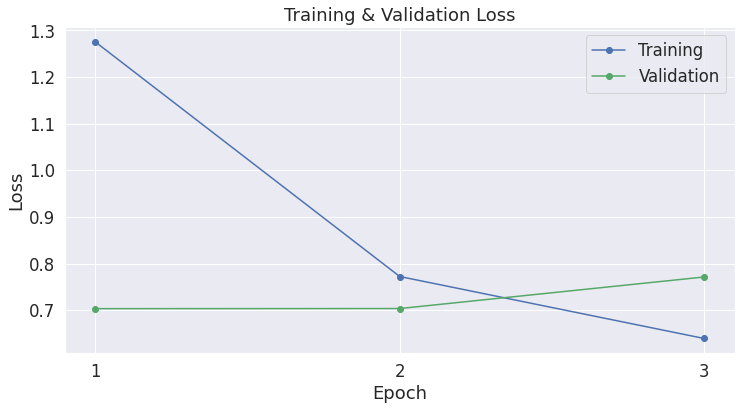

Step 6: Testing data loading...................
Number of test sentences: 361

0    181
1    180
Name: Label, dtype: int64


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Step 6: Testing begins
179 361
[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
# main(df, df_test)  

In [26]:
from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
# from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import PopulationBasedTraining
def main(num_samples=10):

  tokenizer = loadBert() 
  df, df_test= readFile()

  # train_size = [150,300,450,600,750,900,1050,1200,1350,1500,1650,1800,1950,2150]
  # train_size = [300,600,900,1200,1500,1800,2100,2400,2700,3000,3300,3600,3900,4200,4450]
  # train_size = [100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1420]
  train_size = [100]
  x = len(df)
  for i in train_size:
      fac = i/x 
      df_train, dummy = train_test_split(df,test_size=(1-fac),stratify=df['Label'])
      print('df:',len(df),'df_train:',len(df_train),'df_test:', len(df_test),'dummy:',len(dummy))
      config = {
        "lr": tune.loguniform(2e-5, 3e-5, 5e-5),
        "batch_size": tune.choice([16, 32]),
        "num_epochs": tune.choice([2, 3, 4])
      }
      scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="eval_acc",
        mode="max",
        perturbation_interval=2,
        hyperparam_mutations={
            "lr": lambda: tune.loguniform(2e-5, 3e-5, 5e-5).func(None),
            "batch_size": [16, 32, 64],
        })
      analysis = tune.run(
        tune.with_parameters(trainingProcess, df=df_train),
        resources_per_trial={
            "cpu": 1,
            "gpu": 1
        },
        config=config,
        metric="eval_acc",
        mode="max",
        num_samples=num_samples,
        scheduler=scheduler
        # ,
        # name="tune_transformer_pbt"
      )
      best_config = analysis.get_best_config(metric="eval_acc", mode="max")
      print(best_config)
      best_checkpoint = recover_checkpoint(
      analysis.get_best_trial(metric="eval_acc",
                            mode="max").checkpoint.value)
      print(best_checkpoint)
      best_model = BertForNextSentencePrediction.from_pretrained(
      best_checkpoint).to("cuda")
      # to debug the status of the ray tune temporary test process is commentted
      # testingProcess(best_model,best_batch_size,df_test)
      print("*"*80)
  pass


In [27]:
main()

Loading BERT tokenizer...
1431 361
df: 1431 df_train: 100 df_test: 361 dummy: 1331


TypeError: ignored